# ICS485 - Machine learning project

This project is done by:
- Suhaib Abdulrahim Abdullatif `201821340`
- Omar Jarallah Alghamdi `201855000`

In [254]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, accuracy_score, mutual_info_score, f1_score, matthews_corrcoef, confusion_matrix
from imblearn.metrics import geometric_mean_score

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

## Step 1: Reading the Dataset

Lets load the data from the file.

In [255]:
data_df = pd.read_csv('./Dataset-vf.csv')
display(data_df.head())

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,Y
0,2709,59.0,11,120,43,150,228,217,120,2114,0.66,269,FC11,CA49,R1,Melon
1,2802,54.0,7,0,0,693,224,225,136,162,0.35,195,FC11,CA50,NaN,Melon
2,2325,28.0,12,0,0,1260,215,213,133,162,0.89,750,FC14,CA26,NaN,Carrot
3,2837,112.0,8,272,16,3649,235,231,128,6221,0.27,-155,FC11,CA32,NaN,Orange
4,2509,59.0,7,134,10,900,226,226,134,5184,0.93,88,FC11,CA38,NaN,Melon


## Step 2: Feature Transformation and Engineering (Preprocessing)

### A. Dealing With Missing Values 

In this section we are going to check if there is any feature that has missing values. Dealing with missing values is an important step in machine learning, dealing with them properly is an important step to improve the results of the model.

We have decided that:
- if a feature has more than 50% of its records missing, then we are going to drop it.
- if less, then are going to assign the mean of the feature to them. However, it is an important step to check if there are any outliers in the feature.

In [256]:
# get the number of null values for each feature in our data_df
data_df.isnull().sum()

X1        0
X2      627
X3        0
X4        0
X5        0
X6        0
X7        0
X8        0
X9        0
X10       0
X11       0
X12       0
X13       0
X14       0
X15    5743
Y         0
dtype: int64

As we can see above, 5743 out of 6374 (about 90.1%) of the values are missing for the feature X15. Therefore, one way to handle this is by dropping the entire column (feature).

In [257]:
# get the features from the data_df (excluding X15)
data_df = data_df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'Y']]

For feature X2, we are going to replace the missing values with the mean. However, before working with feature X2, we need to split the data to calculate the mean of the train data only

### Splitting the data (training, testing)
We will split the data by the following:
- `80%` of the data will be for the training set.
- `20%` of the data will be for the testing set.

In [258]:
# split into train-test
data_train=data_df.sample(frac=0.8,random_state=707)
data_test=data_df.drop(data_train.index)


# X_train=data_train.drop('Y', axis=1)
# X_test=data_test.drop('Y', axis=1)

X_train=data_train.iloc[:,:-1]
X_test=data_test.iloc[:,:-1]

y_train = data_train.iloc[:,-1]
y_test = data_test.iloc[:,-1]

print('X_data={}'.format(data_df.iloc[:,:-1].shape))
print('X_train={}, X_test={}'.format(X_train.shape, X_test.shape))
print('y_train={}, y_test={}'.format(y_train.shape, y_test.shape))
print()

print("Number of unique classes = {}".format(len(pd.unique(data_df['Y']))))

X_data=(6374, 14)
X_train=(5099, 14), X_test=(1275, 14)
y_train=(5099,), y_test=(1275,)

Number of unique classes = 7


Before calculating the mean, we should first check if X2 has any outliers that would affect the mean.

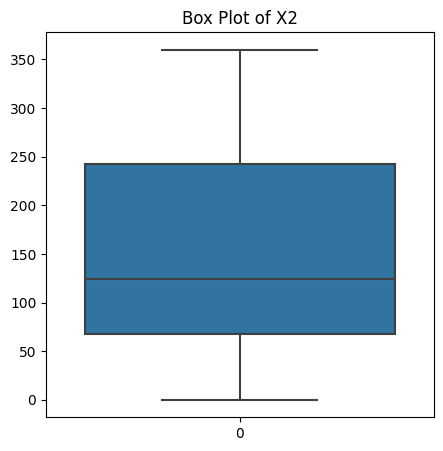

In [259]:
# Boxplot to describe the distribution of the data to detect the existance of outliers
plt.figure(figsize=(5, 5))
plt.title("Box Plot of X2")
sns.boxplot(X_train["X2"])
plt.show()

Since no outliers exist within feature X2, then we can safely replace the missing values with the mean.

In [260]:
# replace the missing values of feature X2 by the mean
X2_mean = X_train["X2"].mean()
X_train["X2"].fillna(X2_mean, inplace=True)
X_test["X2"].fillna(X2_mean, inplace=True)
# now cheack again for missing values
print('The number of missing values for each feature in train data:')
X_train.isnull().sum()

The number of missing values for each feature in train data:


X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
dtype: int64

In [261]:
print('The number of missing values for each feature in test data:')
X_test.isnull().sum()

The number of missing values for each feature in test data:


X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
dtype: int64

Now all the features have no missing which means it is ready to play with.

### B. Dealing with imbalanced data

In this section we will chexk if there is a data imbalance in our dataset. Imbalanced data is a major issue in machine learning, which makes it difficult to correlate features, differentiate classes, and evaluate models. So, we have to use some methods to overcome this issue.

Lets display the distribution of the classes and see if there is an imbalance in the data.

In [262]:
# display the distribution of the classes
def displayDist():
    counts = y_train.value_counts()
    plt.subplots(figsize=(8, 5))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title("Distribution of target labels")
    plt.xlabel("Target classes")
    plt.ylabel("Counts")
    plt.show()

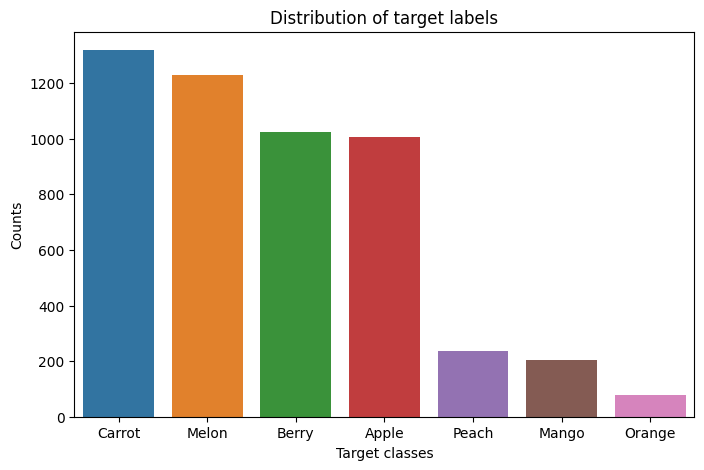

In [263]:
displayDist()

As we can see, there is a high imbalance in the data. One way to overcome this is by using Synthetic Minority Oversampling Technique (SMOTE). SMOTE works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

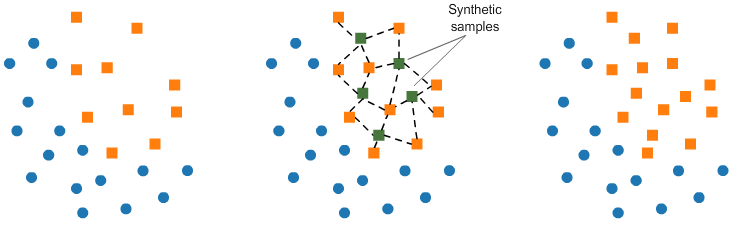

Source: https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

For this purpose, we are going to use <b>imblearn</b> library to do the oversampling for us. Note that we are going to use SMOTE-NC variant of SMOTE since our data contains both numerical and categorical features.

In [264]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(random_state=777, categorical_features=[12, 13])
X_train, y_train = sm.fit_resample(X_train, y_train)

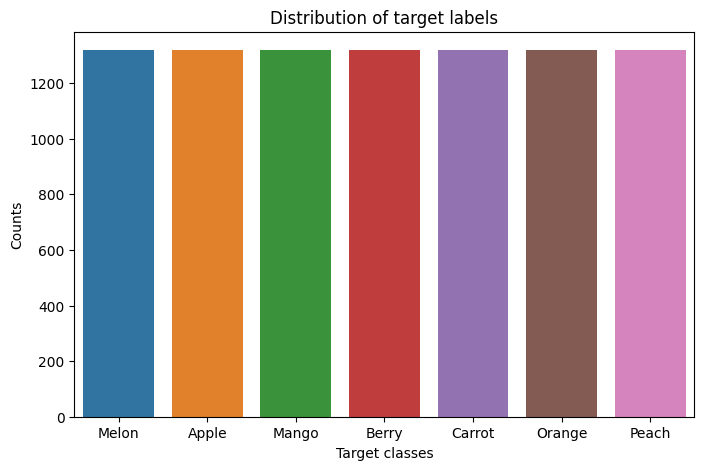

In [265]:
# now display the new class distribution
displayDist()

As we can see now, our data is uniformly distributed.

### C. Dealing with categorical values

Machine learning models cannot deal with raw non-numiric data, so, in this section we are going to use some methods to transform the non-numiric data to numiric form.

In [266]:
print('The non-numiric columns in the features data frame are: {}'.format(data_df.iloc[:,:-1].select_dtypes(exclude='number').columns.values))
print('Is there a non-numiric value in the labels data frame? {}'.format(not data_df.iloc[:,-1].str.isnumeric().all()))

The non-numiric columns in the features data frame are: ['X13' 'X14']
Is there a non-numiric value in the labels data frame? True


As we can see that the labels and some features contain categorical values. we will check the cardinality to select the encoding method.

In [267]:
print('The unique values of X13 = {}'.format((np.unique(data_df.iloc[:,:-1]["X13"]))))
print('\nThe unique values of X14 = {}'.format((np.unique(data_df.iloc[:,:-1]["X14"]))))
print('\nThe unique classes of Y = {}'.format((np.unique(data_df.iloc[:,-1]))))

The unique values of X13 = [' FC11' ' FC12' ' FC13' ' FC14']

The unique values of X14 = [' CA21' ' CA22' ' CA23' ' CA24' ' CA25' ' CA26' ' CA30' ' CA31' ' CA32'
 ' CA33' ' CA34' ' CA36' ' CA37' ' CA38' ' CA39' ' CA40' ' CA41' ' CA42'
 ' CA43' ' CA44' ' CA46' ' CA48' ' CA49' ' CA50' ' CA51' ' CA52' ' CA53'
 ' CA54' ' CA55' ' CA58' ' CA59' ' CA60']

The unique classes of Y = ['Apple' 'Berry' 'Carrot' 'Mango' 'Melon' 'Orange' 'Peach']


Since we have relatively low cardinality of values in X13 and Y, we are going to use one-hot encoding to convert them into numerical values. However, for X14 we are going to use binary encoding since it has a high cardinality.

Binary encoding is a combination of Hash encoding and one-hot encoding and work well with high cardinality values. For this purpose, we are going to use the library: category_encoders 

In [268]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['X14'], return_df=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test) 
X_train = pd.get_dummies(X_train, columns=["X13"])
X_test = pd.get_dummies(X_test, columns=["X13"])

In [269]:
display(X_train)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X14_0,X14_1,X14_2,X14_3,X14_4,X13_ FC11,X13_ FC12,X13_ FC13,X13_ FC14
0,2706,76.000000,30,108,47,124,240,171,39,1717,...,232,0,0,0,0,1,1,0,0,0
1,2703,139.000000,15,0,0,2329,241,234,119,579,...,113,0,0,0,1,0,0,0,1,0
2,3020,259.000000,8,134,10,3234,200,245,184,1006,...,-910,0,0,0,1,1,0,0,1,0
3,2633,171.000000,10,0,0,1173,227,245,149,752,...,858,0,0,1,0,0,0,0,1,0
4,3265,193.000000,14,108,7,4726,218,250,163,2831,...,-368,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9228,3374,153.866168,6,151,5,4226,227,240,147,4041,...,-564,1,0,0,0,1,1,0,0,0
9229,3257,81.665799,10,108,7,3743,233,222,120,1923,...,835,1,0,0,0,1,1,0,0,0
9230,3334,54.069756,13,215,12,3202,229,215,114,1889,...,694,1,0,0,0,1,1,0,0,0
9231,3280,219.743238,15,401,53,4075,202,251,182,2262,...,-916,0,1,1,1,0,1,0,0,0


In [270]:
display(X_test)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X14_0,X14_1,X14_2,X14_3,X14_4,X13_ FC11,X13_ FC12,X13_ FC13,X13_ FC14
1,2802,54.000000,7,0,0,693,224,225,136,162,...,195,0,0,0,0,1,1,0,0,0
2,2325,28.000000,12,0,0,1260,215,213,133,162,...,750,0,0,0,1,0,0,0,0,1
3,2837,112.000000,8,272,16,3649,235,231,128,6221,...,-155,0,0,0,1,1,1,0,0,0
10,2104,134.000000,15,0,0,1380,243,231,113,859,...,-826,0,0,1,0,0,0,0,0,1
14,2251,105.000000,22,30,11,1505,251,207,72,351,...,716,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6334,2481,62.000000,9,175,38,190,228,221,125,1786,...,147,0,0,0,1,0,0,0,0,1
6351,2275,153.178222,25,212,88,1026,251,196,58,1284,...,-717,0,0,1,0,1,0,0,0,1
6359,2947,179.000000,27,150,29,255,220,244,140,792,...,822,1,0,0,0,1,0,0,1,0
6364,3063,90.000000,2,297,-37,658,222,236,150,1517,...,396,0,1,0,1,1,1,0,0,0


In [271]:
print("The number of non-numiric columns in the train features data frame is: {}".format(len(X_train.select_dtypes(exclude='number').columns.values)))
print("The number of non-numiric columns in the test features data frame is: {}".format(len(X_test.select_dtypes(exclude='number').columns.values)))

The number of non-numiric columns in the train features data frame is: 0
The number of non-numiric columns in the test features data frame is: 0


As we can see, we have dealt with the categorical data.

Transforming the labels:

In [272]:
oe = OneHotEncoder()
le = LabelEncoder()
y_train_oe = oe.fit_transform(y_train.to_numpy().reshape(-1,1)).toarray()
y_test_oe = oe.fit_transform(y_test.to_numpy().reshape(-1,1)).toarray()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)

### D. Dataset Analysis 

#### i. Information about train features

In [273]:
# basic information of the train features.
display(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9233 entries, 0 to 9232
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X1         9233 non-null   int64  
 1   X2         9233 non-null   float64
 2   X3         9233 non-null   int64  
 3   X4         9233 non-null   int64  
 4   X5         9233 non-null   int64  
 5   X6         9233 non-null   int64  
 6   X7         9233 non-null   int64  
 7   X8         9233 non-null   int64  
 8   X9         9233 non-null   int64  
 9   X10        9233 non-null   int64  
 10  X11        9233 non-null   float64
 11  X12        9233 non-null   int64  
 12  X14_0      9233 non-null   int64  
 13  X14_1      9233 non-null   int64  
 14  X14_2      9233 non-null   int64  
 15  X14_3      9233 non-null   int64  
 16  X14_4      9233 non-null   int64  
 17  X13_ FC11  9233 non-null   uint8  
 18  X13_ FC12  9233 non-null   uint8  
 19  X13_ FC13  9233 non-null   uint8  
 20  X13_ FC1

None

We can see that we have already solved the missing values and categorical values problems within our data. 

### ii. Features Statistics



Now let us have some statistics about the features:

In [274]:
# basic statistics of the features
display(X_train.describe())

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X14_0,X14_1,X14_2,X14_3,X14_4,X13_ FC11,X13_ FC12,X13_ FC13,X13_ FC14
count,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,...,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000,9233.000000
mean,2705.109282,156.216910,16.498213,191.547276,44.614751,1885.066934,211.008448,217.293946,134.863425,1961.915520,...,-12.736164,0.334886,0.549659,0.415250,0.386332,0.567530,0.412650,0.001950,0.268927,0.316474
std,411.436810,100.219275,8.591188,160.929346,51.761153,1552.038130,32.284621,22.682903,44.476725,1590.605828,...,572.013506,0.471976,0.497555,0.492792,0.486934,0.495446,0.492338,0.044113,0.443426,0.465125
min,1874.000000,0.000000,1.000000,0.000000,-134.000000,0.000000,0.000000,99.000000,0.000000,30.000000,...,-1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2331.000000,76.000000,10.000000,65.000000,7.000000,754.000000,196.000000,206.000000,108.000000,780.000000,...,-513.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2738.000000,137.000000,15.000000,157.000000,28.000000,1329.000000,220.000000,222.000000,137.000000,1475.000000,...,-27.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3064.000000,230.000000,23.000000,278.000000,68.000000,2697.000000,233.000000,233.000000,165.000000,2572.000000,...,499.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,3675.000000,360.000000,52.000000,1129.000000,334.000000,6836.000000,254.000000,254.000000,248.000000,6853.000000,...,1000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### iii. Features Distribution



Lets plot the distribution of the features so we can get a better understading on how are the data distributed in each feature.

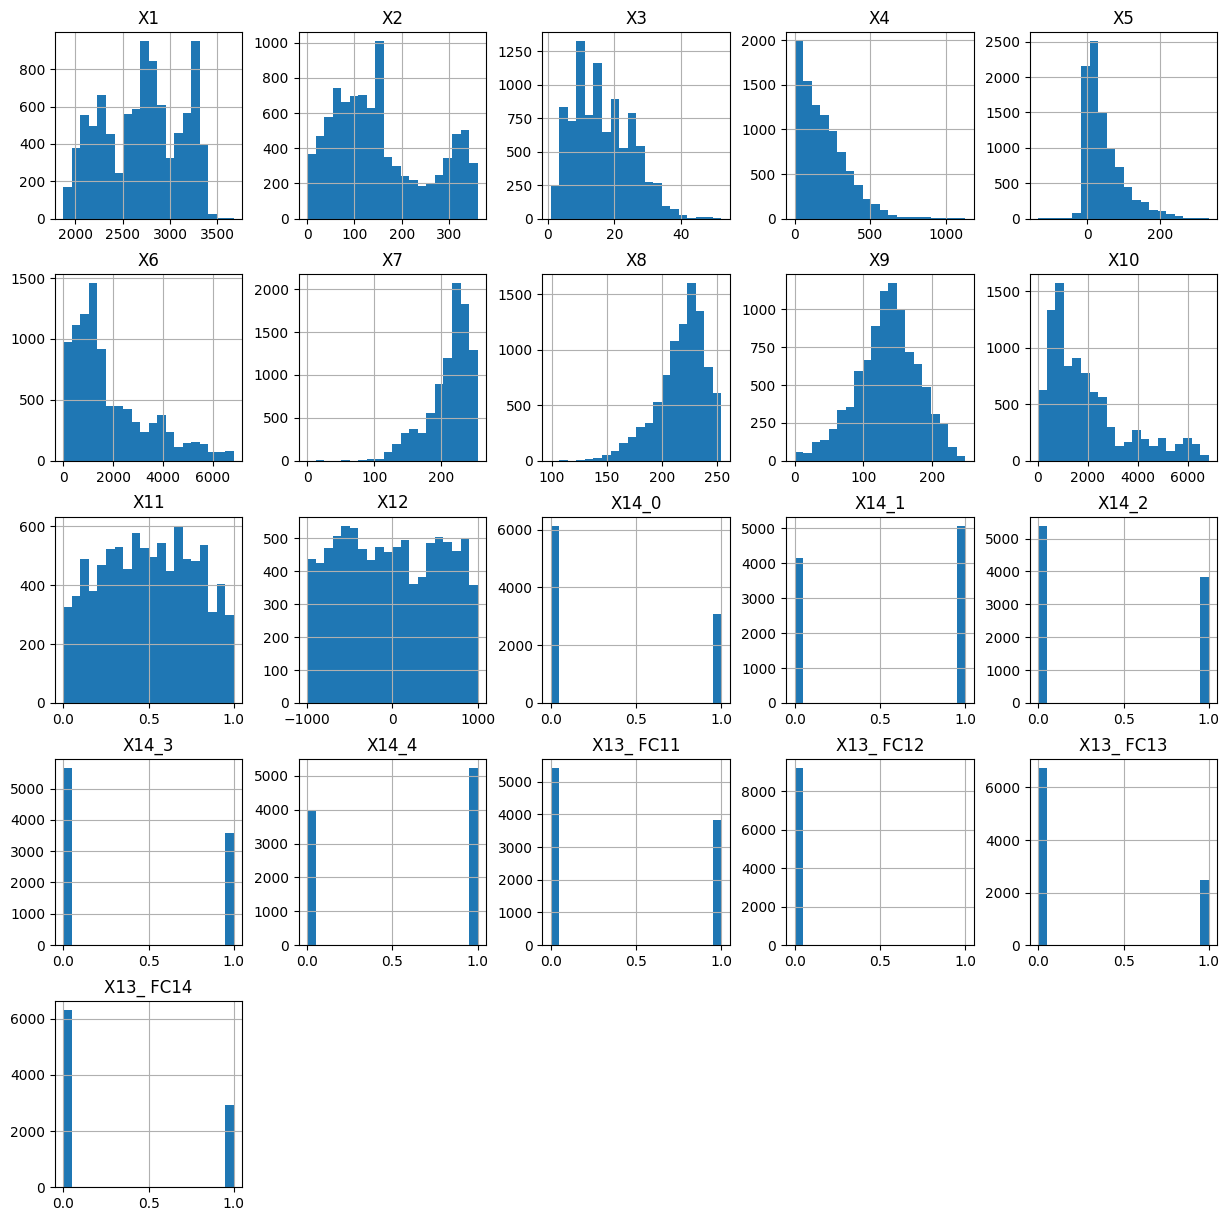

In [275]:
# distribution of features
X_train.hist(figsize=(15, 15), bins=20)
plt.show()

### iv. Correlation Analysis

A correlation could be positive, meaning both variables move in the same direction, or negative, meaning that when one variable’s value increases, the other variables’ values decrease. Correlation can also be neutral or zero, meaning that the variables are unrelated.

<AxesSubplot: >

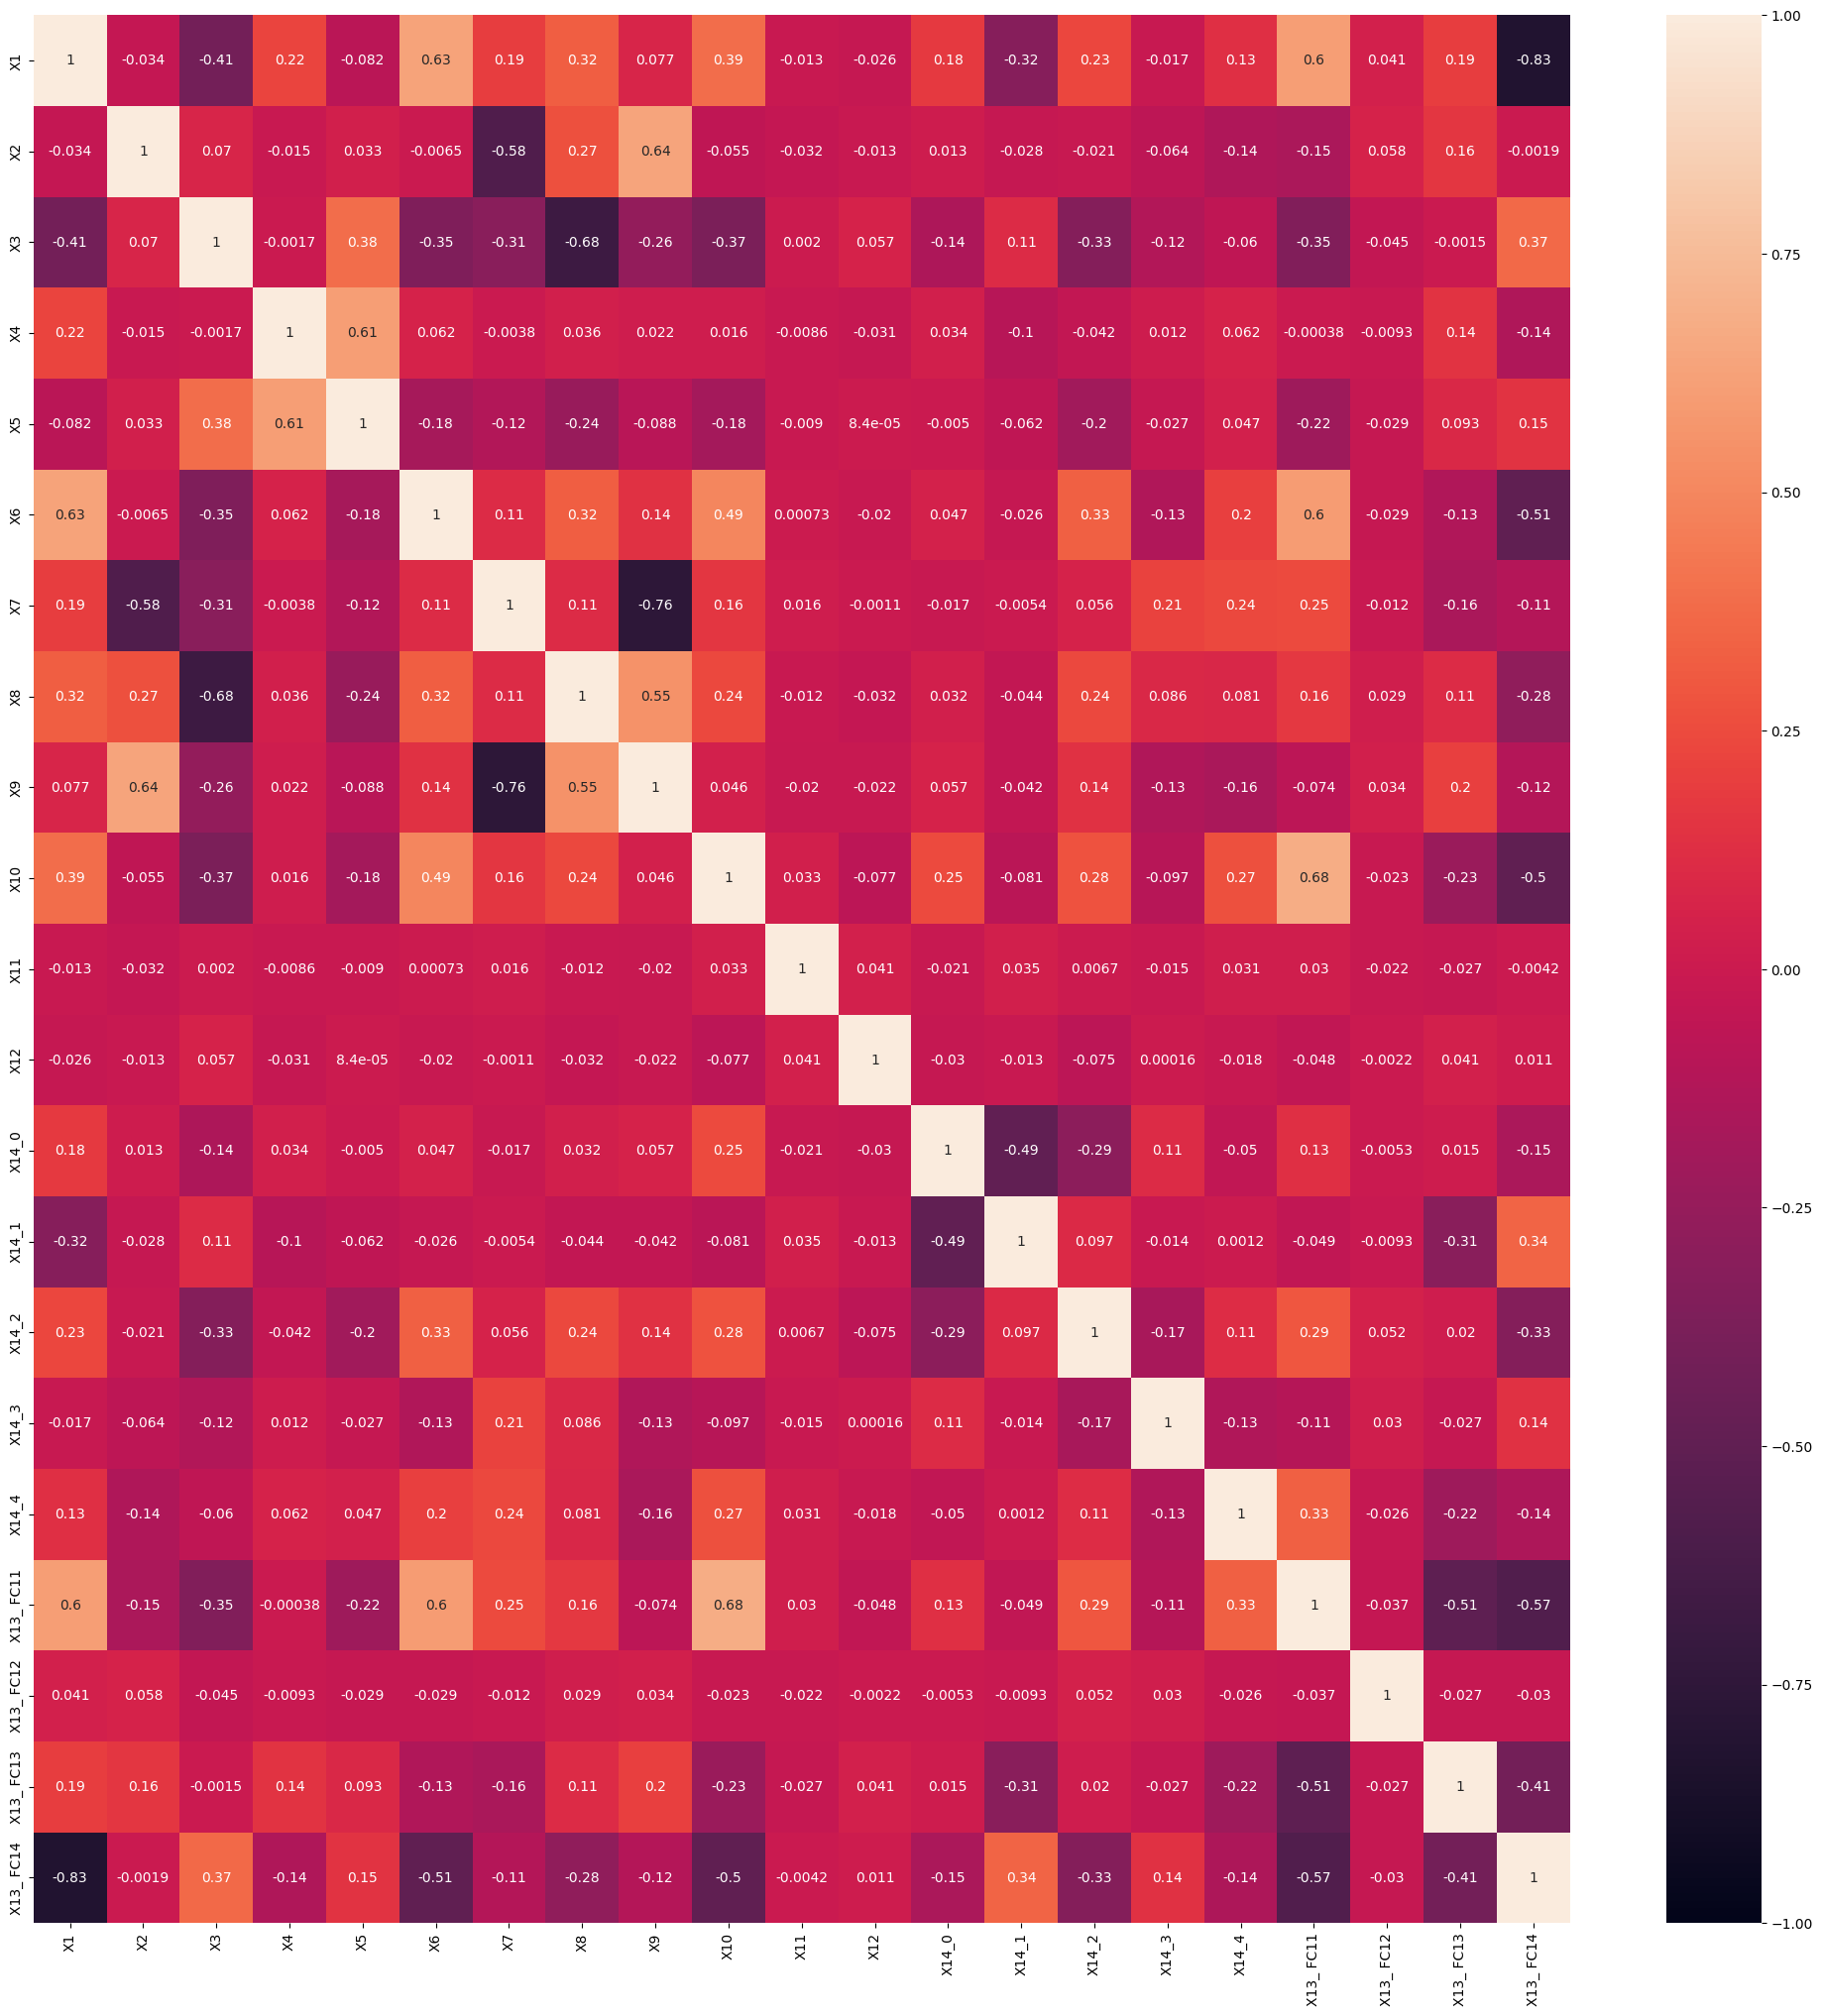

In [276]:
# Correlation analysis
fig, ax = plt.subplots(figsize=(25,25)) 
sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True, ax=ax)

Having high correlated feature will benefit us when we apply feature selection.

### vi. Feature Scaling

Feature scaling the method used to standardize the range of features of data. Since, the range of values of data may vary widely, it becomes a necessary step in data preprocessing while using machine learning algorithms. There are some rules that will help to make the model to get better results:

<br>

***Data-centric heuristics include the following:***
1. If the data has outliers, use standardization or robust scaling.

2. If the data has a gaussian distribution, use standardization.

3. If the data has a non-normal distribution, use normalization.

<br>

***Model-centric rules include these:***

1. If the modeling algorithm assumes (but does not require) a normal distribution of the residuals (i.e., regularized linear regression, regularized logistic regression, or linear discriminant analysis), use standardization.

2. If the modeling algorithm makes no assumptions about the distribution of the data (i.e., k-nearest neighbors, support vector machines, and artificial neural networks), then use normalization.

<br>

In each use case, the rule proposes a mathematical fit with either the data or the learning model.

We will save the headers to display the features labels when ploting the destribution before and after rescaling.

In [277]:
headers = X_train.columns.values.tolist()

#### a. Standard Scaling

`StandardScaler` standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation. 

- `StandardScaler` does not meet the strict definition of scale I introduced earlier.

- `StandardScaler` results in a distribution with a standard deviation equal to 1. The variance is equal to 1 also, because variance = standard deviation squared. And 1 squared = 1.

- `StandardScaler` makes the mean of the distribution approximately 0.

In [278]:
std_scaler = StandardScaler()

In [279]:
std_scaler.fit(X_train)

str_X_train = std_scaler.transform(X_train.copy())
str_X_test = std_scaler.transform(X_test.copy())

Training data before standered scaling


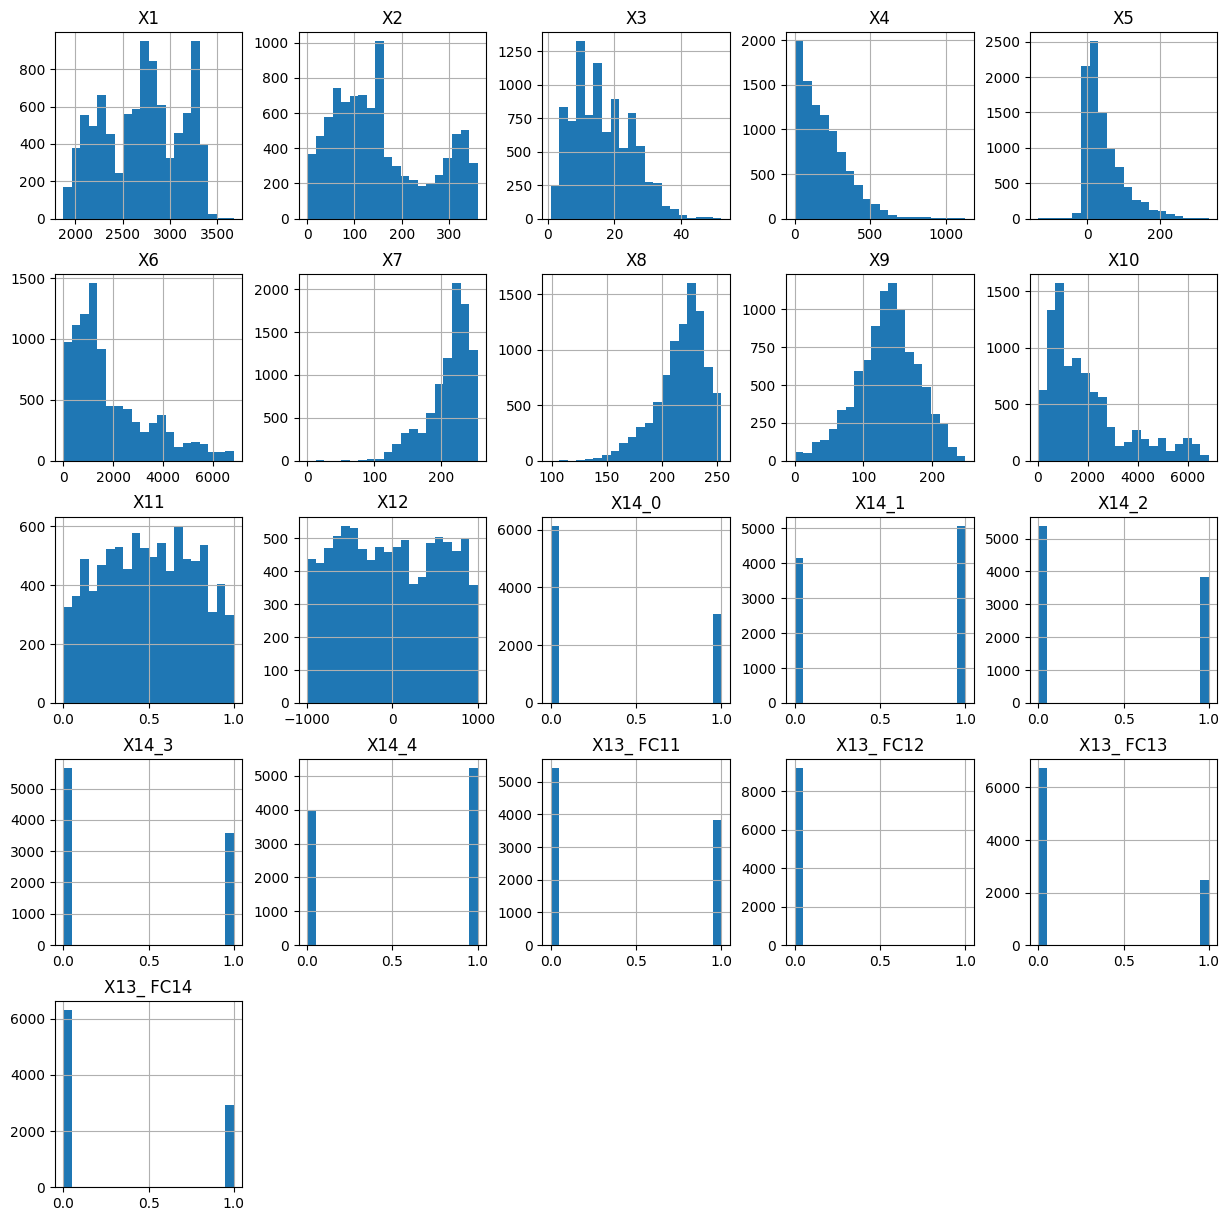

Training data after standered scaling


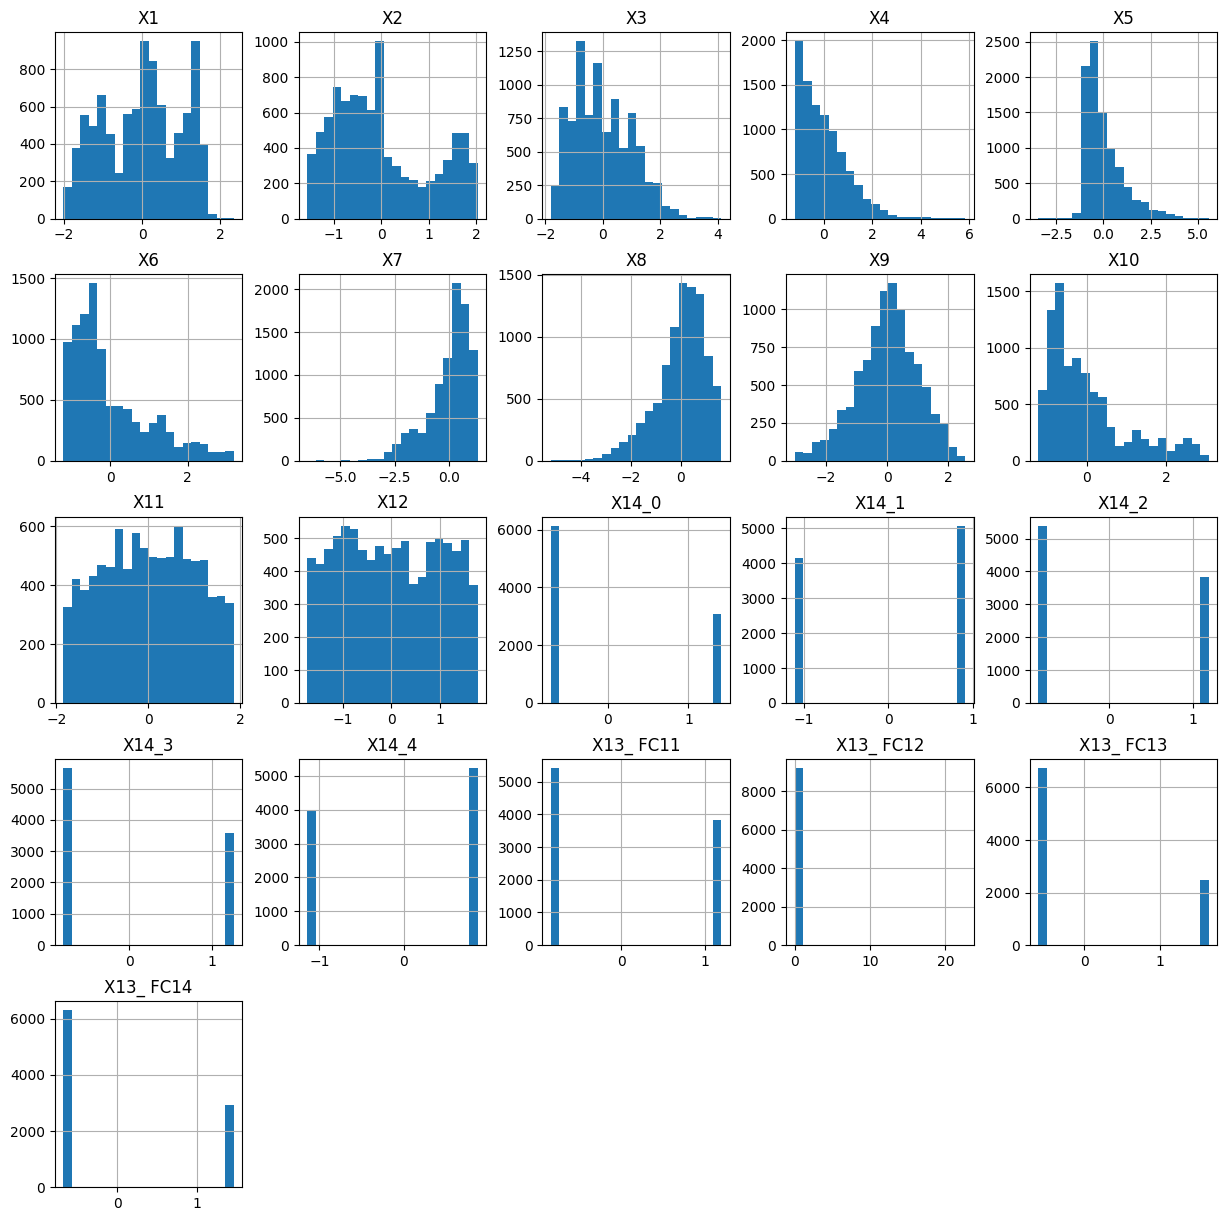

In [280]:
train_df = pd.DataFrame(X_train, columns = headers)
train_df.hist(figsize=(15, 15), bins=20)
print("Training data before standered scaling")
plt.show()
str_train_df = pd.DataFrame(str_X_train, columns = headers)
str_train_df.hist(figsize=(15, 15), bins=20)
print("Training data after standered scaling")
plt.show()

#### b. Min-Max Scaling

For each value in a feature, `MinMaxScaler` subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum.

- `MinMaxScaler` preserves the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data.

- `MinMaxScaler` doesn’t reduce the importance of outliers.

- The default range for the feature returned by MinMaxScaler is 0 to 1.

In [281]:
mm_scaler = MinMaxScaler()

In [282]:
mm_scaler.fit(X_train)

mm_X_train = mm_scaler.transform(X_train.copy())
mm_X_test = mm_scaler.transform(X_test.copy())

Training data before min max scaling scaling


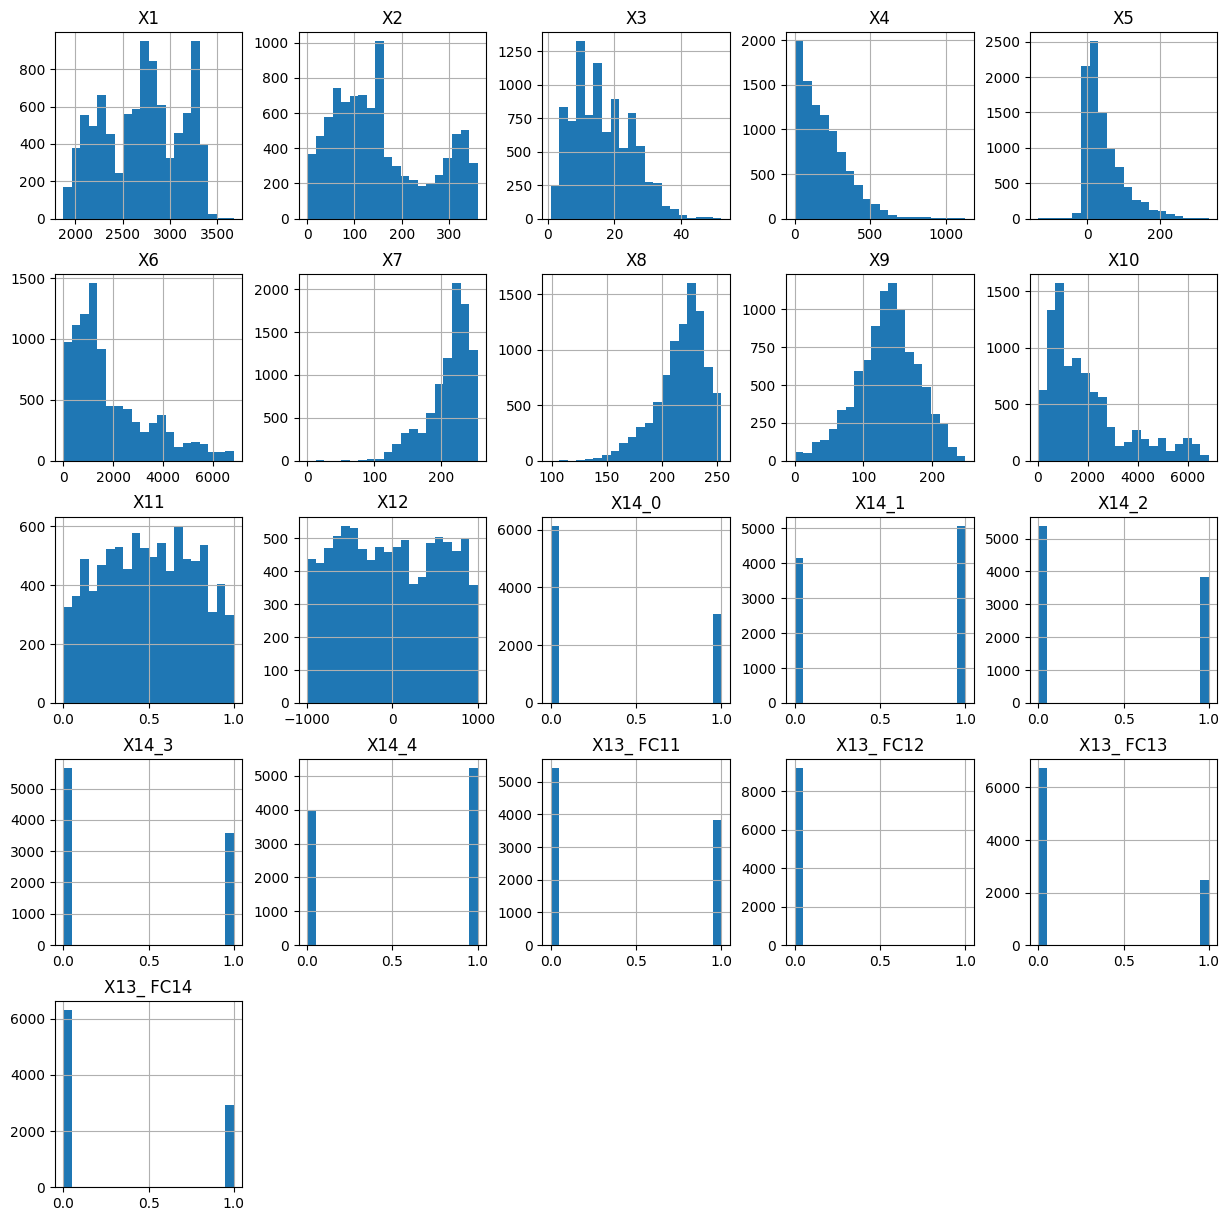

Training data after min max scaling


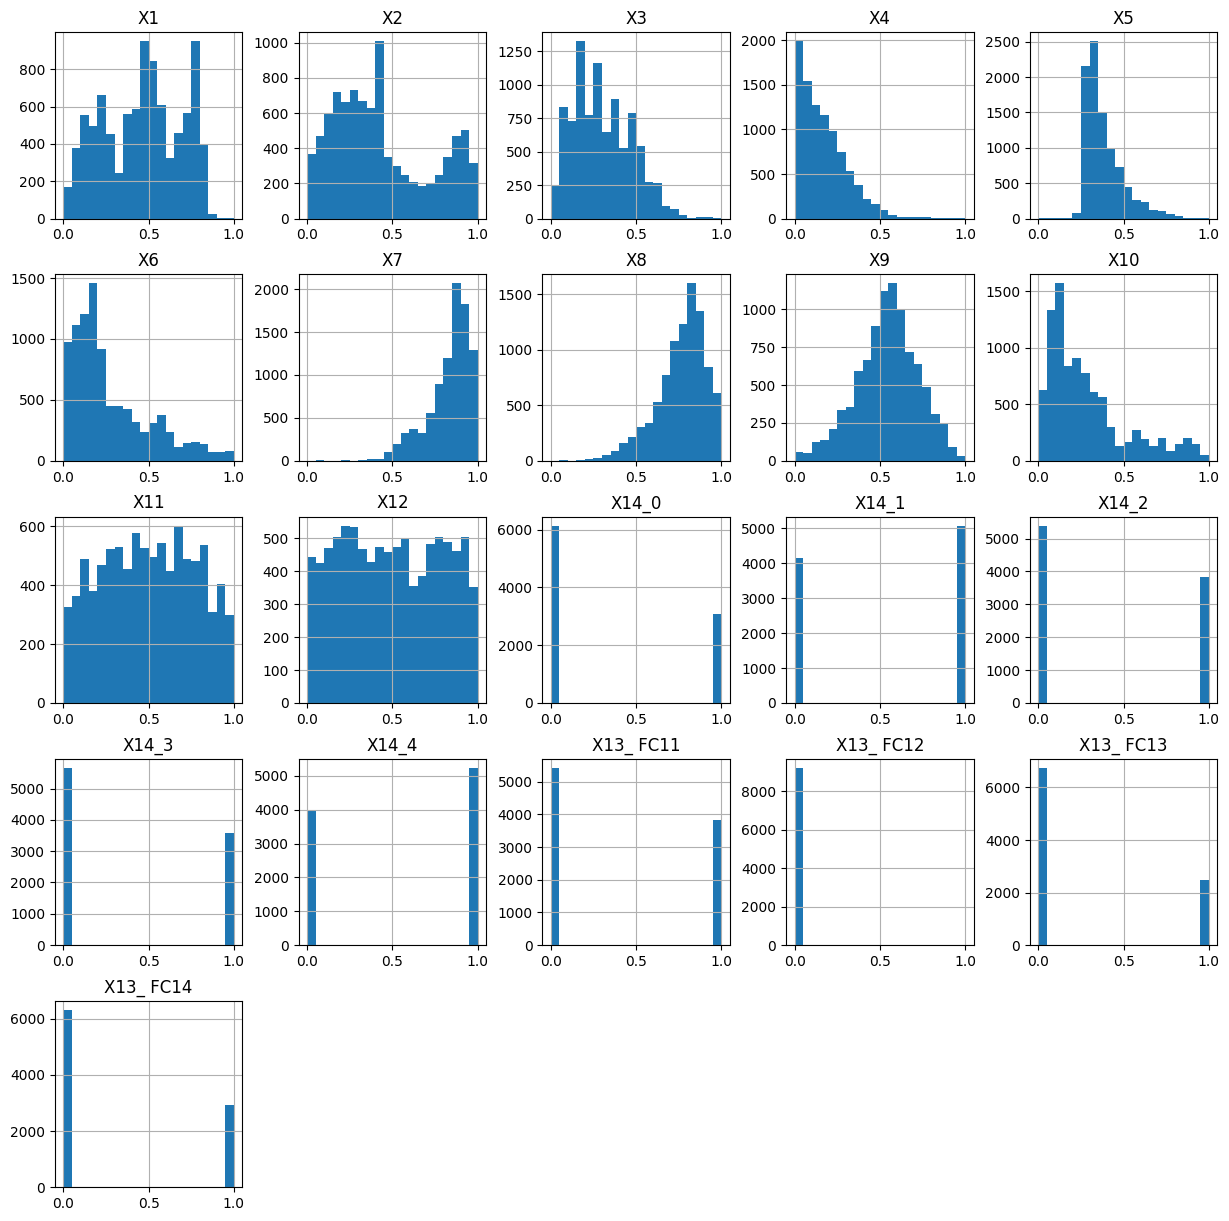

In [283]:
train_df = pd.DataFrame(X_train, columns = headers)
train_df.hist(figsize=(15, 15), bins=20)
print("Training data before min max scaling scaling")
plt.show()
mm_train_df = pd.DataFrame(mm_X_train, columns = headers)
mm_train_df.hist(figsize=(15, 15), bins=20)
print("Training data after min max scaling")
plt.show()

#### C. Robust Scaling

`RobustScaler` transforms the feature vector by subtracting the median and then dividing by the interquartile range (75% value — 25% value).

Like MinMaxScaler, our feature with large values — normal-big — is now of similar scale to the other features. Note that RobustScaler does not scale the data into a predetermined interval like MinMaxScaler.

- The range for each feature after `RobustScaler` is applied is larger than it was for `MinMaxScaler`.

- We should se `RobustScaler` if we want to reduce the effects of outliers, relative to `MinMaxScaler`.

In [284]:
robust_scaler = RobustScaler()

In [285]:
robust_scaler.fit(X_train)

robust_X_train = robust_scaler.transform(X_train.copy())
robust_X_test = robust_scaler.transform(X_test.copy())

Training data before robust scaling scaling


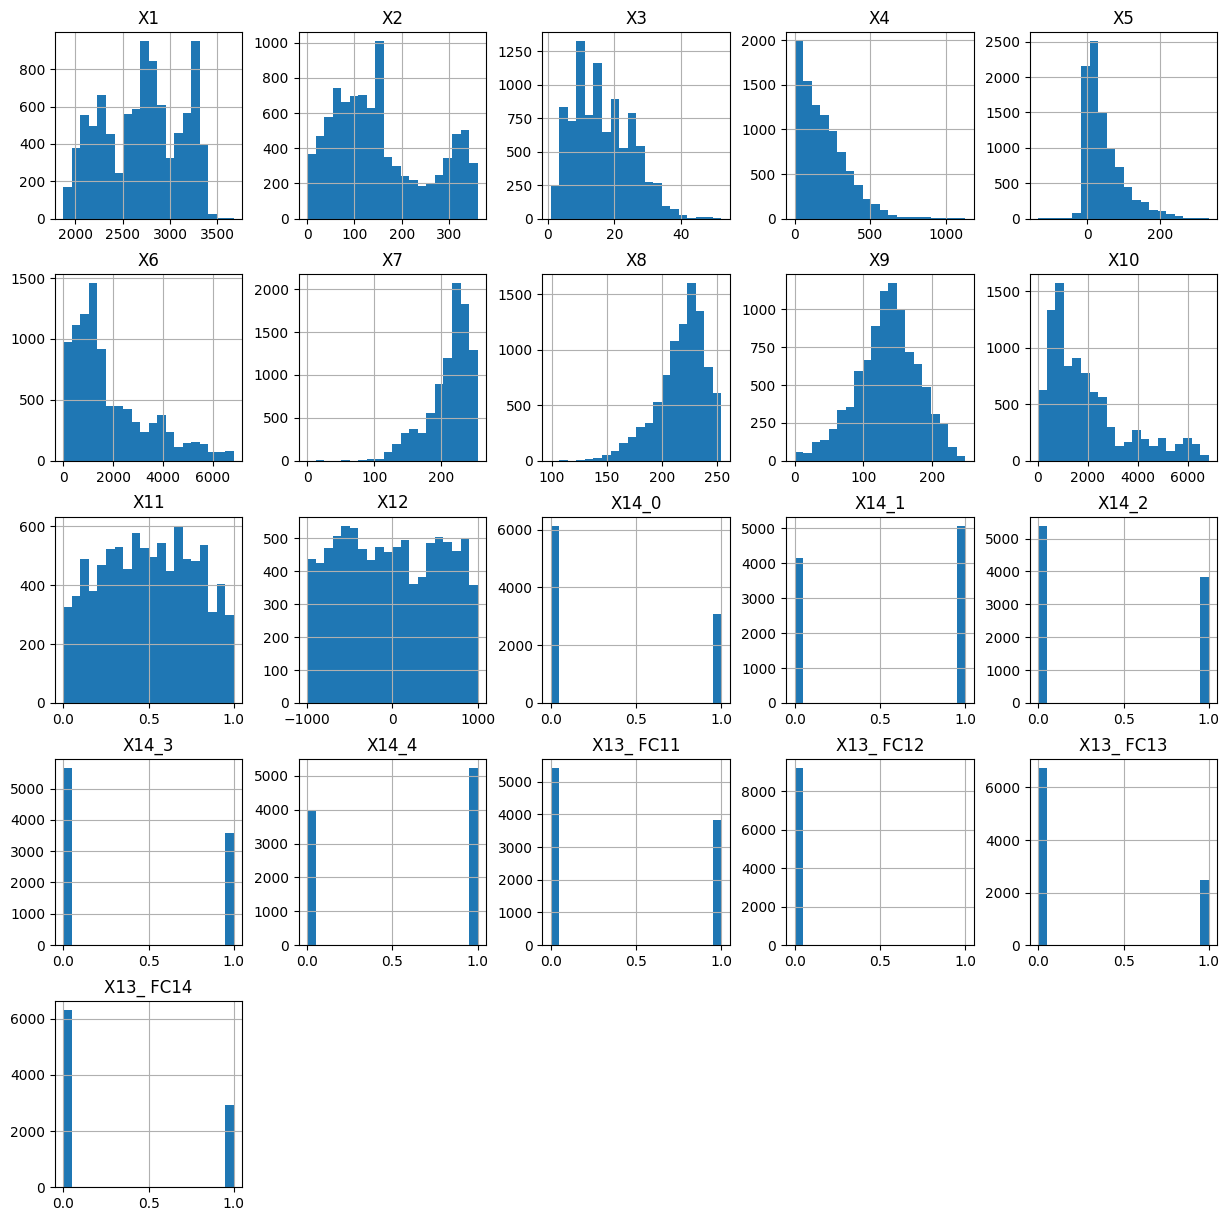

Training data after robust scaling


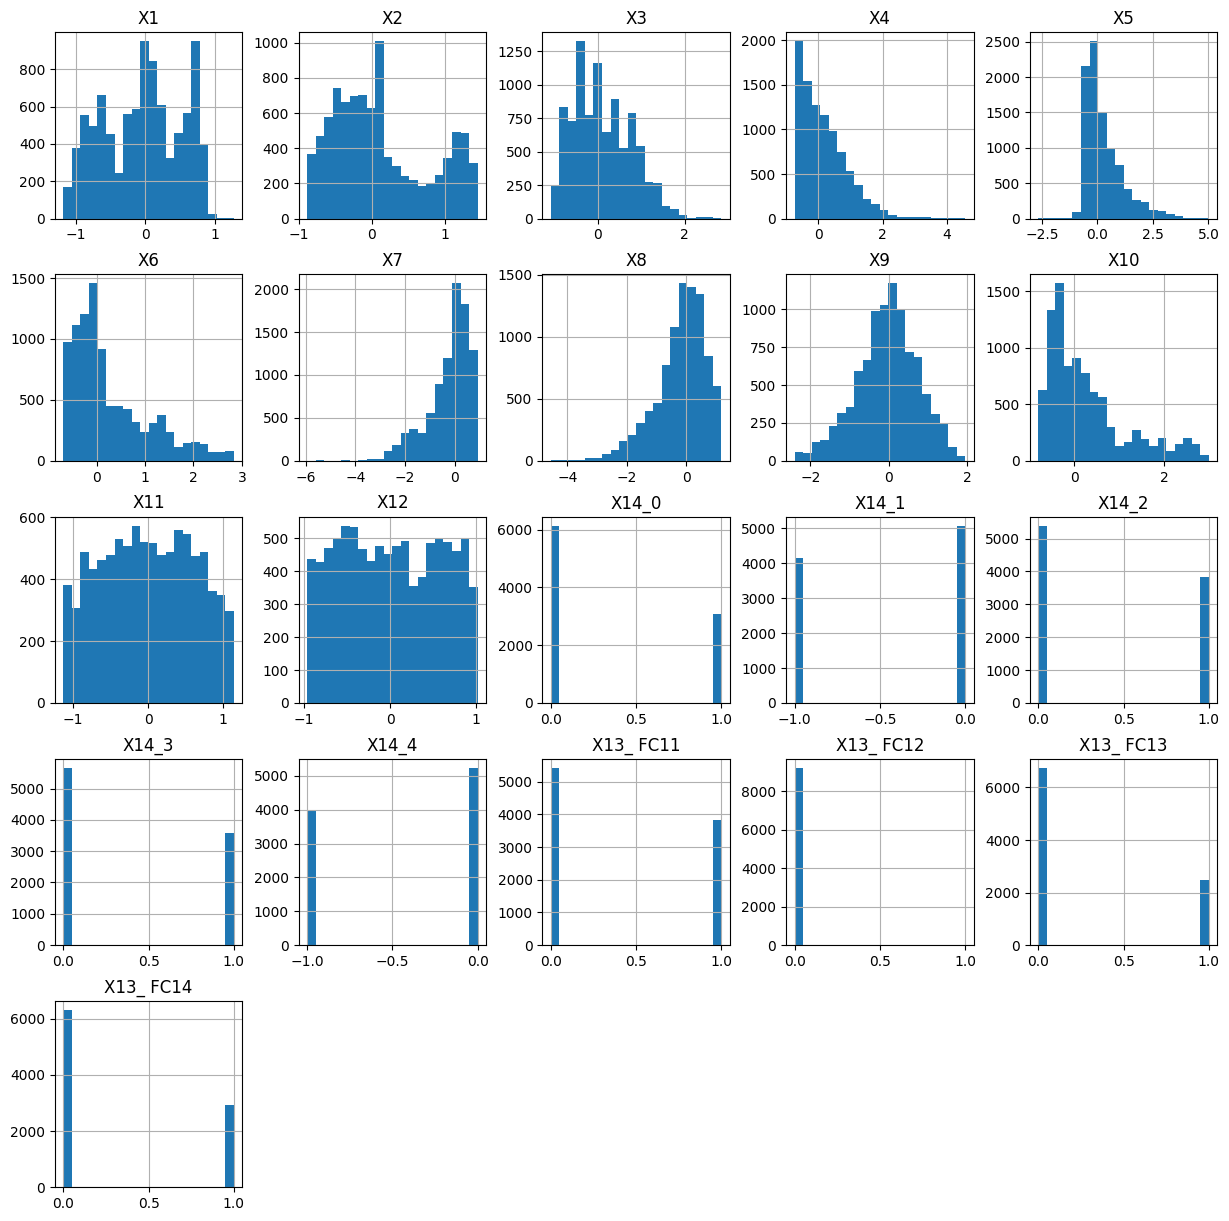

In [286]:
train_df = pd.DataFrame(X_train, columns = headers)
train_df.hist(figsize=(15, 15), bins=20)
print("Training data before robust scaling scaling")
plt.show()
robust_train_df = pd.DataFrame(robust_X_train, columns = headers)
robust_train_df.hist(figsize=(15, 15), bins=20)
print("Training data after robust scaling")
plt.show()

#### D. Normal Scaling

***`Normalizer` works on the rows, not the columns***

By default, `L2` normalization is applied to each observation so the that the values in a row have a unit norm. Unit norm with `L2` means that if each element were squared and summed, the total would equal 1.

- `Normalizer` does transform all the features to values between -1 and 1.
- Scaling inputs to unit norms is a common operation for text classification or clustering.

In [287]:
normal_scaler = Normalizer(norm="l2")

In [288]:
normal_X_train = normal_scaler.transform(X_train.copy())
normal_X_test = normal_scaler.transform(X_test.copy())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Normalizer was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Normalizer was fitted without feature names
  warnings.warn(


Training data before normal scaling scaling


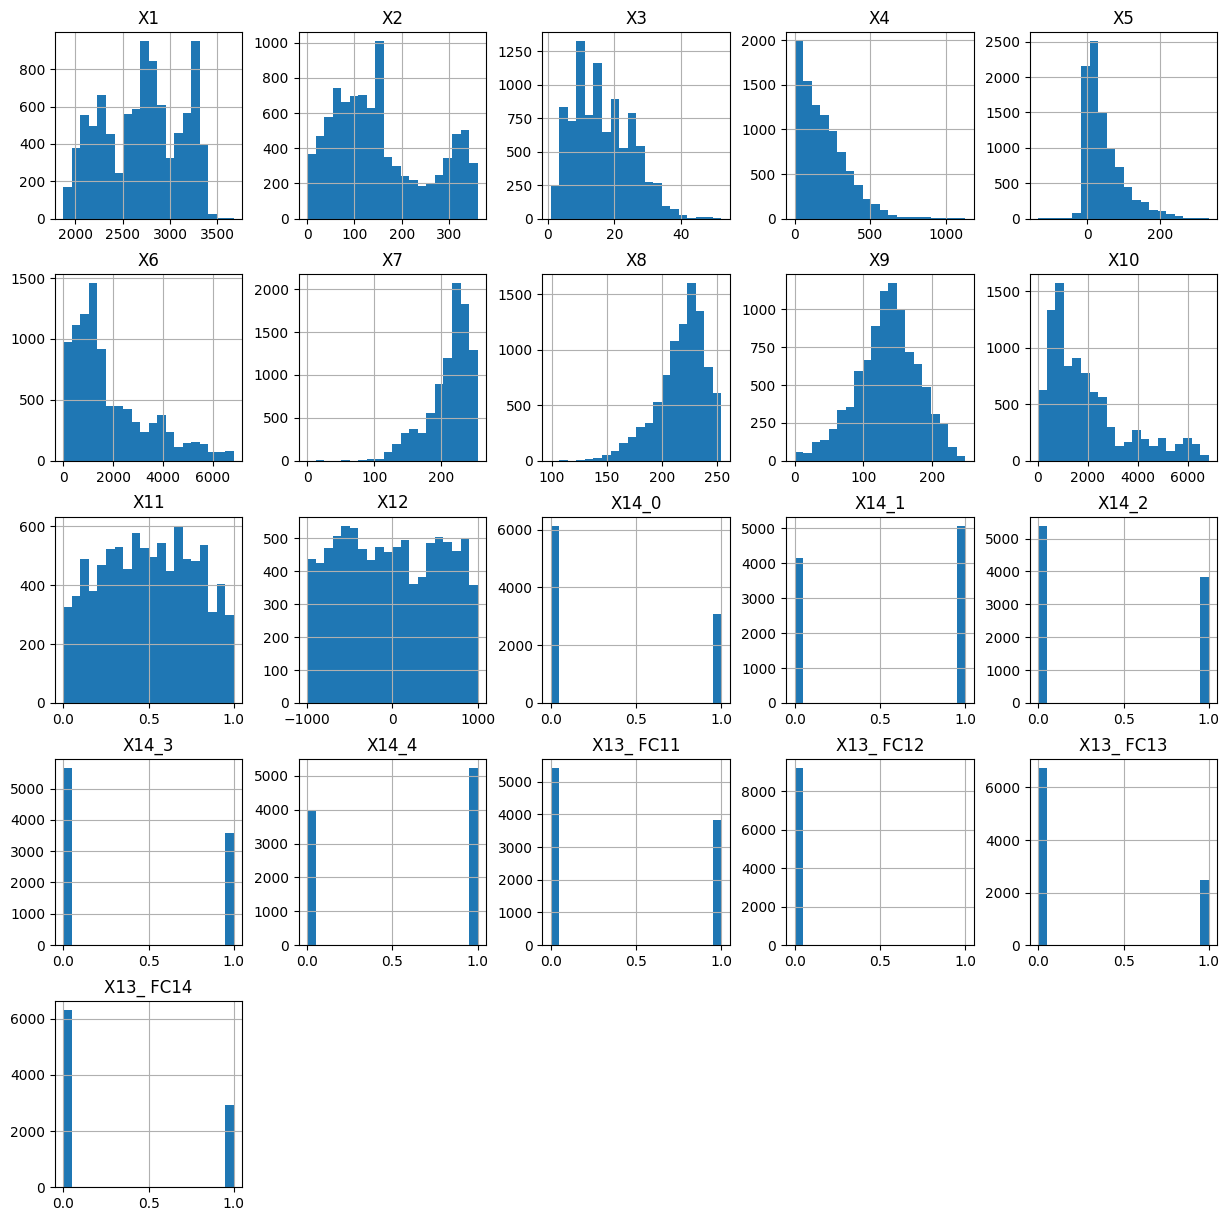

Training data after normal scaling


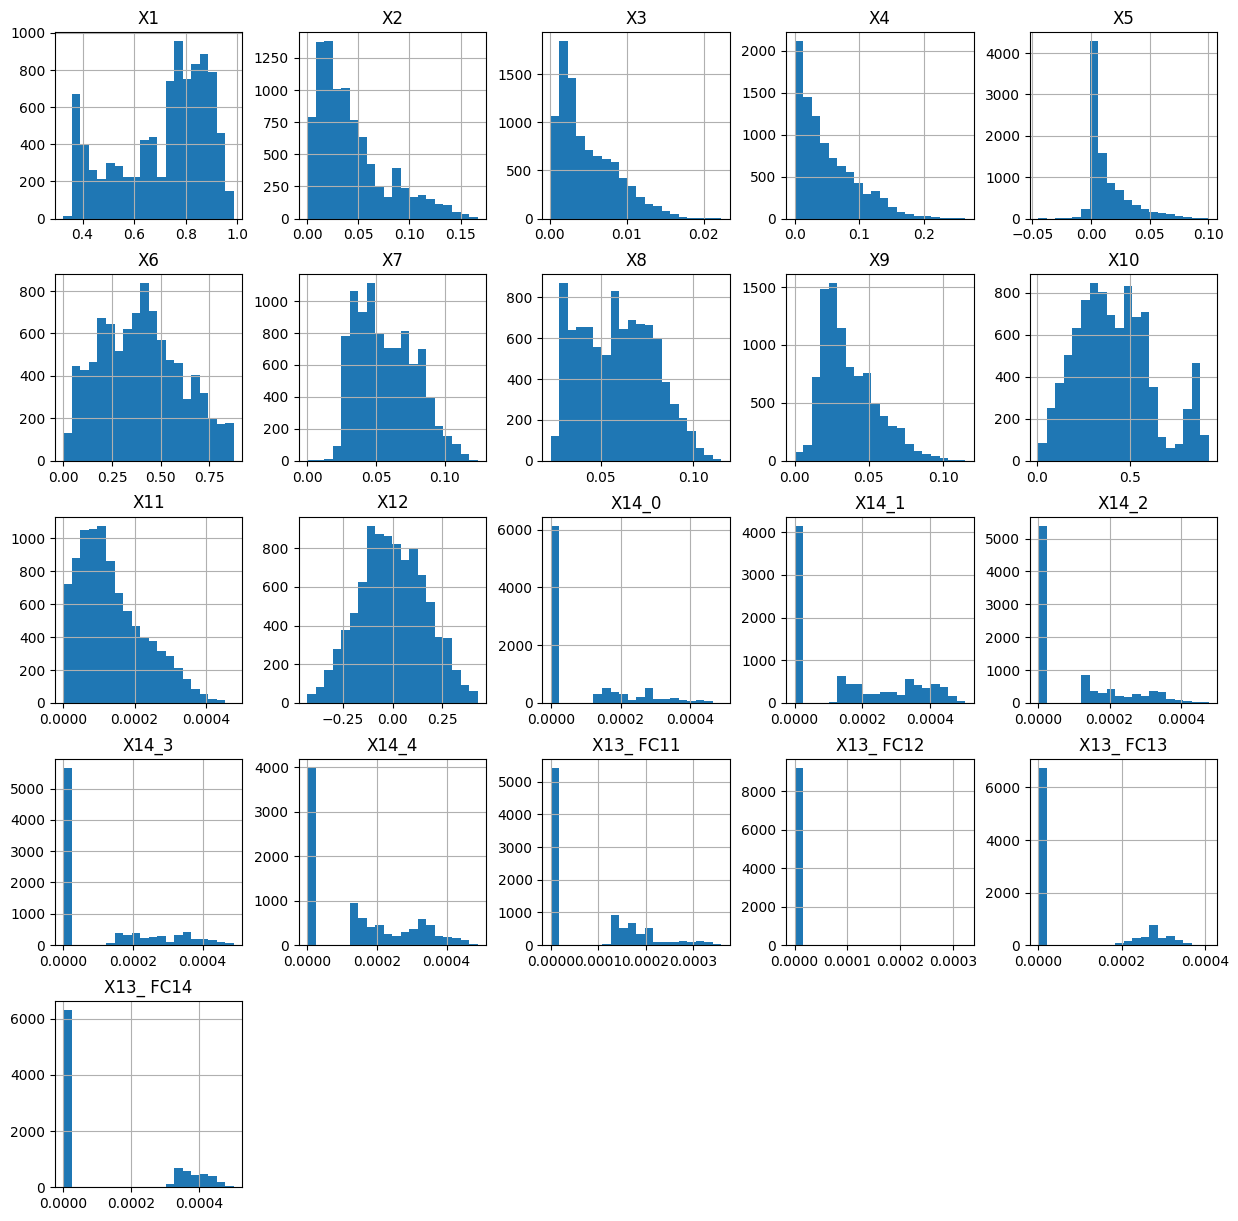

In [289]:
train_df = pd.DataFrame(X_train, columns = headers)
train_df.hist(figsize=(15, 15), bins=20)
print("Training data before normal scaling scaling")
plt.show()
normal_train_df = pd.DataFrame(normal_X_train, columns = headers)
normal_train_df.hist(figsize=(15, 15), bins=20)
print("Training data after normal scaling")
plt.show()

### vii. Feature Selection

Feature selection is used in the machine learning process to improve accuracy. It also improves the algorithms' prediction power by selecting the most important variables and removing the redundant and irrelevant ones.

***The advantages of feature selection can be summed up as:***

- Decreases over-fitting: Less redundant data means less chances of making decisions based on noise.
- Reduces training time: Less data means that the algorithms train sooner.
- Improved accuracy: Less ambiguous data means improvement of modeling accuracy.

One of the most common machine learning algorithms is random forests. They are so successful because they provide strong prediction accuracy, low overfitting, and simple interpretability in general. This interpretability is provided by the ease with which each variable's influence on the tree decision may be determined. In other words, it is simple to determine how much each variable contributes to the decision (Feature selection). 

**How does Random forest select features?**

Random forests consist of 4 –12 hundred decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or combination of features. At each node (this is at each question), the three divides the dataset into 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived from how “pure” each of the buckets is.



*In all feature selection procedures, it is a good practice to select the features by examining only the training set. This is to avoid overfitting. So, we are going to use the training set only to fit the data.*

Let us get the number of estimators for the random forest:

In [290]:
import math
estimators = math.ceil(math.sqrt(len(headers)))
estimators

5

So we are going to use 5 estimators for the random forest

In [291]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = estimators))
sel.fit(str_X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=5))

To see which features are important we can use `get_support` method on the fitted model.



In [292]:
sel.get_support()

array([ True, False, False,  True, False,  True,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True])

We can now make a list and count the selected features.

In [293]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

6

To get the name of the features selected

In [294]:
print(selected_feat.to_list())

['X1', 'X4', 'X6', 'X7', 'X10', 'X13_ FC14']


Let us split a new training set after feature selection to do comparisons later

In [295]:
selected_X_train = X_train.loc[:,(sel.get_support())]

selected_X_test = X_test.loc[:,(sel.get_support())]

print('X_train={}, X_test={}'.format(selected_X_train.shape, selected_X_test.shape))
print('y_train={}, y_test={}'.format(y_train.shape, y_test.shape))

X_train=(9233, 6), X_test=(1275, 6)
y_train=(9233,), y_test=(1275,)


### viii. Dimensionality Reduction

Dimensionality reduction, an unsupervised machine learning method is used to reduce the number of feature variables for each data sample selecting set of principal features.Many techniques have been developed for this purpose, but `Principal Component Analysis (PCA)` is one of the oldest and most widely used. Its idea is simple to reduce the dimensionality of a dataset, while preserving as much ‘variability’ (i.e. statistical information) as possible. 

`PCA` is a statistical technique to convert high dimensional data to low dimensional data by selecting the most important features that capture maximum information about the dataset. The features are selected on the basis of variance that they cause in the output. The feature that causes highest variance is the first principal component. The feature that is responsible for second highest variance is considered the second principal component, and so on. It is important to mention that principal components do not have any correlation with each other.

Advantages of `PCA`:

- Data Visualization

- Speeding the machine learning algorithms.

In [351]:
pca = PCA(n_components=2, whiten=True, random_state=666)

In [352]:
# Reascale all x data.
mm_train_features = mm_scaler.transform(X_train.to_numpy().copy())
mm_test_features = mm_scaler.transform(X_test.to_numpy().copy())

# Execute PCA
reduced_X_train = pca.fit_transform(mm_train_features)
reduced_X_test = pca.fit_transform(mm_test_features)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


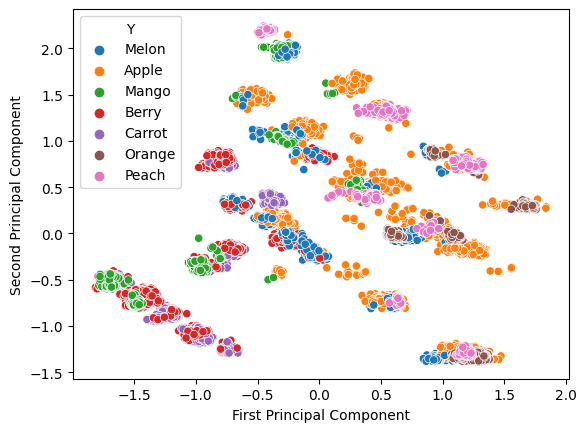

In [355]:
sns.scatterplot(x=reduced_X_train[:,0], y=reduced_X_train[:,1], hue=y_train)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.show()

In [356]:
print('X_train={}, X_test={}'.format(reduced_X_train.shape, reduced_X_test.shape))
print('y_train={}, y_test={}'.format(y_train.shape, y_test.shape))

X_train=(9233, 2), X_test=(1275, 2)
y_train=(9233,), y_test=(1275,)


### ix. Appropriate Evaluation Measures

We will mainly focus on three evaluation measures:

1. F-score: the harmonic mean of the precision and recall since the data given is imbalance. The highest possible value of an F-score is 1.0, indicating perfect precision and recall, and the lowest possible value is 0, if either precision or recall are zero.

2. Matthews Correlation Coefficient (MCC): It's a correlation coefficient between the observed and predicted classifications (it is good even if the classes are of very different sizes). The highest coefficient is +1 representing a perfect prediction, and the lowest is −1 indicating total disagreement between prediction and observation.

3. Geometric Mean (Gmean): a metric that measures the balance between classification performances on both the majority and minority classes. A low G-Mean is an indication of a poor performance in the classification of the positive cases.

## Step 3: Fitting the Models and Hyperparameters Tuning

In almost any Machine Learning project, we train different models on the dataset and select the one with the best performance. However, there is room for improvement as we cannot say for sure that this particular model is best for the problem at hand. Hence, our aim is to improve the model in any way possible. One important factor in the performances of these models are their hyperparameters, once we set appropriate values for these hyperparameters, the performance of a model can improve significantly. 

***To find what is the best model and under which hyperparameters it preforms the best, we will use `GridSearchCV` and `PipeLine` from `sklearn`.***


***What is GridSearchCV?***

`GridSearchCV` is the process of performing hyperparameter tuning in order to determine the optimal values for a given model. As mentioned above, the performance of a model significantly depends on the value of hyperparameters. Note that there is no way to know in advance the best values for hyperparameters so ideally, we need to try all possible values to know the optimal values. Doing this manually could take a considerable amount of time and resources and thus we use `GridSearchCV` to automate the tuning of hyperparameters.


***What is Pipeline***

`Pipeline` is a tool that chains all steps of the workflow together for a more streamlined procedure. The key benefit of building a pipeline is improved readability. Pipelines are able to execute a series of transformations with one call, allowing users to attain results with less code.

### Logistic Regression Classifier

In [299]:
# Create the pipeline
lr_model = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=777))
])

# Define the parameter grid for the grid search
param_grid = {
    'poly__degree': [1, 2, 3],
    'lr__C': [0.1, 1, 10],
    'lr__solver': ['saga'],
    'lr__penalty': ['l1', 'l2'],
    'lr__max_iter': [5000]
}

# Create the grid search object
lr_grid_search = GridSearchCV(lr_model, param_grid, cv=3, n_jobs=-1)

# Fit the grid search to the training data
lr_grid_search.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(random_state=777))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.1, 1, 10], 'lr__max_iter': [5000],
                         'lr__penalty': ['l1', 'l2'], 'lr__solver': ['saga'],
                         'poly__degree': [1, 2, 3]})

In [300]:
lr_best = lr_grid_search.best_estimator_
lr_best_predictions = lr_best.predict(X_test)
print("Accuracy = %.2f"% (accuracy_score(y_test, lr_best_predictions)))
print(classification_report(y_test, lr_best_predictions))

Accuracy = 0.65
              precision    recall  f1-score   support

       Apple       0.66      0.76      0.71       268
       Berry       0.51      0.33      0.40       227
      Carrot       0.75      0.88      0.81       301
       Mango       0.25      0.63      0.36        46
       Melon       0.80      0.58      0.67       340
      Orange       0.50      0.86      0.63        21
       Peach       0.65      0.58      0.61        72

    accuracy                           0.65      1275
   macro avg       0.59      0.66      0.60      1275
weighted avg       0.67      0.65      0.65      1275



Let us try it with feature selection

In [357]:
# Create the pipeline
s_lr_model = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=777))
])

# Define the parameter grid for the grid search
param_grid = {
    'poly__degree': [1, 2, 3],
    'lr__C': [0.1, 1, 10],
    'lr__solver': ['saga'],
    'lr__penalty': ['l1', 'l2'],
    'lr__max_iter': [5000]
}

# Create the grid search object
s_lr_grid_search = GridSearchCV(s_lr_model, param_grid, cv=3, n_jobs=-1)

# Fit the grid search to the training data
s_lr_grid_search.fit(selected_X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(random_state=777))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.1, 1, 10], 'lr__max_iter': [5000],
                         'lr__penalty': ['l1', 'l2'], 'lr__solver': ['saga'],
                         'poly__degree': [1, 2, 3]})

In [358]:
s_lr_best = s_lr_grid_search.best_estimator_
s_lr_best_predictions = s_lr_best.predict(selected_X_test)
print("Accuracy = %.2f"% (accuracy_score(y_test, s_lr_best_predictions)))
print(classification_report(y_test, s_lr_best_predictions))

Accuracy = 0.85
              precision    recall  f1-score   support

       Apple       0.92      0.81      0.86       268
       Berry       0.81      0.78      0.79       227
      Carrot       0.90      0.94      0.92       301
       Mango       0.49      0.74      0.59        46
       Melon       0.92      0.84      0.88       340
      Orange       0.59      0.95      0.73        21
       Peach       0.66      0.89      0.76        72

    accuracy                           0.85      1275
   macro avg       0.76      0.85      0.79      1275
weighted avg       0.86      0.85      0.85      1275



Much better result

### Support Vector Machine Classifier

In [301]:
# Create a pipeline with a scaler and an SVM
svm_model = Pipeline([
    ('scaler', Normalizer()),
    ('svm', SVC())
])

# Create a range of values for the hyperparameters
params = {'svm__kernel': ['linear', 'poly', 'rbf'],
              'svm__C': [0.1, 1, 10],
              'svm__degree': [2, 3],
              'svm__gamma': [0.1, 1]}

# Create a grid search object with 5-fold cross-validation
svm_grid_search = GridSearchCV(svm_model, params, cv=3, n_jobs=-1)

# Fit the grid search object to the training data
svm_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', Normalizer()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10], 'svm__degree': [2, 3],
                         'svm__gamma': [0.1, 1],
                         'svm__kernel': ['linear', 'poly', 'rbf']})

In [302]:
svm_best = svm_grid_search.best_estimator_
svm_best_predictions = svm_best.predict(X_test)
print("Accuracy = %.2f"% (accuracy_score(y_test, svm_best_predictions)))
print(classification_report(y_test, svm_best_predictions))

Accuracy = 0.65
              precision    recall  f1-score   support

       Apple       0.83      0.54      0.66       268
       Berry       0.66      0.41      0.51       227
      Carrot       0.85      0.89      0.87       301
       Mango       0.17      0.70      0.28        46
       Melon       0.77      0.61      0.69       340
      Orange       0.44      1.00      0.61        21
       Peach       0.40      0.78      0.53        72

    accuracy                           0.65      1275
   macro avg       0.59      0.70      0.59      1275
weighted avg       0.74      0.65      0.67      1275



### Decision Tree Classifier

In [303]:
# Create the pipeline
dt_model = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=777))
])
# Create a range of values for the hyperparameters
params = {
    'dt__max_depth': [5, 10, 20, 30],
    'dt__min_samples_leaf': [5, 10, 20, 50],
    'dt__criterion': ["gini", "entropy"]
}

# Instantiate the grid search model
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=params, cv=10, n_jobs=-1)

# Fit the grid search object to the training data
dt_grid_search.fit(X_train, y_train)
score_df = pd.DataFrame(dt_grid_search.cv_results_)

In [304]:
dt_best = dt_grid_search.best_estimator_
dt_best_predictions = dt_best.predict(X_test)
print("Accuracy = %.2f"% (accuracy_score(y_test, dt_best_predictions)))
print(classification_report(y_test, dt_best_predictions))

Accuracy = 0.84
              precision    recall  f1-score   support

       Apple       0.83      0.85      0.84       268
       Berry       0.73      0.81      0.76       227
      Carrot       0.93      0.86      0.89       301
       Mango       0.64      0.74      0.69        46
       Melon       0.90      0.87      0.89       340
      Orange       0.75      0.86      0.80        21
       Peach       0.77      0.68      0.72        72

    accuracy                           0.84      1275
   macro avg       0.79      0.81      0.80      1275
weighted avg       0.84      0.84      0.84      1275



### K-Nearest Neighbors Classifier

In [305]:
# Create the pipeline
knn_model = Pipeline([
    ('scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])

# Create a range of values for the hyperparameters
params = {'knn__n_neighbors': [3, 5, 7, 9, 13, 15],
              'knn__algorithm': ['auto', 'ball_tree', 'kd_tree']}

# Create a grid search object with 5-fold cross-validation
knn_grid_search = GridSearchCV(knn_model, params, cv=10, n_jobs=-1)

# Fit the grid search object to the training data
knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', Normalizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'knn__n_neighbors': [3, 5, 7, 9, 13, 15]})

In [306]:
knn_best = knn_grid_search.best_estimator_
knn_best_predictions = knn_best.predict(X_test)
print("Accuracy = %.2f"% (accuracy_score(y_test, knn_best_predictions)))
print(classification_report(y_test, knn_best_predictions))

Accuracy = 0.63
              precision    recall  f1-score   support

       Apple       0.62      0.58      0.60       268
       Berry       0.53      0.50      0.52       227
      Carrot       0.72      0.73      0.73       301
       Mango       0.27      0.50      0.35        46
       Melon       0.74      0.64      0.69       340
      Orange       0.58      0.86      0.69        21
       Peach       0.63      0.83      0.72        72

    accuracy                           0.63      1275
   macro avg       0.59      0.66      0.61      1275
weighted avg       0.65      0.63      0.64      1275



In [359]:
# Create the pipeline
s_knn_model = Pipeline([
    ('scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])

# Create a range of values for the hyperparameters
params = {'knn__n_neighbors': [3, 5, 7, 9, 13, 15],
              'knn__algorithm': ['auto', 'ball_tree', 'kd_tree']}

# Create a grid search object with 5-fold cross-validation
s_knn_grid_search = GridSearchCV(s_knn_model, params, cv=10, n_jobs=-1)

# Fit the grid search object to the training data
s_knn_grid_search.fit(selected_X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', Normalizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'knn__n_neighbors': [3, 5, 7, 9, 13, 15]})

In [361]:
s_knn_best = s_knn_grid_search.best_estimator_
s_knn_best_predictions = s_knn_best.predict(selected_X_test)
print("Accuracy = %.2f"% (accuracy_score(y_test, s_knn_best_predictions)))
print(classification_report(y_test, s_knn_best_predictions))

Accuracy = 0.74
              precision    recall  f1-score   support

       Apple       0.74      0.59      0.66       268
       Berry       0.63      0.58      0.60       227
      Carrot       0.83      0.91      0.87       301
       Mango       0.42      0.72      0.53        46
       Melon       0.83      0.75      0.79       340
      Orange       0.68      1.00      0.81        21
       Peach       0.64      0.96      0.77        72

    accuracy                           0.74      1275
   macro avg       0.68      0.79      0.72      1275
weighted avg       0.75      0.74      0.74      1275



### Random Forest Classifier

In [307]:
# Create the pipeline
rf_model = Pipeline([
    ('rf', RandomForestClassifier())
])

# Define the hyperparameters that you want to tune
params = {
    'rf__n_estimators': [5, 10, 50],
    'rf__max_depth': [None, 5, 10],
}

# Create the grid search object
rf_grid_search = GridSearchCV(rf_model, params, cv=3, n_jobs=-1)

# Fit the grid search to the training data
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 5, 10],
                         'rf__n_estimators': [5, 10, 50]})

In [308]:
rf_best = rf_grid_search.best_estimator_
rf_best_predictions = rf_best.predict(X_test)
print("Accuracy = %.2f"% (accuracy_score(y_test, rf_best_predictions)))
print(classification_report(y_test, rf_best_predictions))

Accuracy = 0.87
              precision    recall  f1-score   support

       Apple       0.87      0.88      0.88       268
       Berry       0.78      0.81      0.80       227
      Carrot       0.94      0.88      0.91       301
       Mango       0.74      0.63      0.68        46
       Melon       0.89      0.96      0.93       340
      Orange       0.85      0.81      0.83        21
       Peach       0.78      0.65      0.71        72

    accuracy                           0.87      1275
   macro avg       0.84      0.80      0.82      1275
weighted avg       0.87      0.87      0.87      1275



### Adaboost Classifier

In [317]:
# Create the pipeline
pipeline = Pipeline([
    ('ab', AdaBoostClassifier(DecisionTreeClassifier(random_state=777), random_state=777))
])

# Define the hyperparameters that you want to tune
params = {
    'ab__n_estimators': [100, 1000, 2000, 5000],
    'ab__learning_rate': [0.0001 ,0.001, 0.01],
    'ab__base_estimator__max_depth': [5, 10, 15]
}

# Create the grid search object
ab_grid_search = GridSearchCV(pipeline, params, cv=3, n_jobs=-1)

# Fit the grid search to the training data
ab_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ab',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=777),
                                                           random_state=777))]),
             n_jobs=-1,
             param_grid={'ab__base_estimator__max_depth': [5, 10, 15],
                         'ab__learning_rate': [0.0001, 0.001, 0.01],
                         'ab__n_estimators': [100, 1000, 2000, 5000]})

In [318]:
ab_best = ab_grid_search.best_estimator_
ab_best_predictions = ab_best.predict(X_test)
print("Accuracy = %.2f"% (accuracy_score(y_test, ab_best_predictions)))
print(classification_report(y_test, ab_best_predictions))

Accuracy = 0.88
              precision    recall  f1-score   support

       Apple       0.93      0.95      0.94       268
       Berry       0.76      0.80      0.78       227
      Carrot       0.90      0.88      0.89       301
       Mango       0.74      0.61      0.67        46
       Melon       0.93      0.94      0.93       340
      Orange       0.90      0.90      0.90        21
       Peach       0.93      0.78      0.85        72

    accuracy                           0.88      1275
   macro avg       0.87      0.84      0.85      1275
weighted avg       0.88      0.88      0.88      1275



In [362]:
# Create the pipeline
pipeline = Pipeline([
    ('ab', AdaBoostClassifier(DecisionTreeClassifier(random_state=777), random_state=777))
])

# Define the hyperparameters that you want to tune
params = {
    'ab__n_estimators': [100, 1000, 2000, 5000],
    'ab__learning_rate': [0.0001 ,0.001, 0.01],
    'ab__base_estimator__max_depth': [5, 10, 15]
}

# Create the grid search object
s_ab_grid_search = GridSearchCV(pipeline, params, cv=3, n_jobs=-1)

# Fit the grid search to the training data
s_ab_grid_search.fit(selected_X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ab',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=777),
                                                           random_state=777))]),
             n_jobs=-1,
             param_grid={'ab__base_estimator__max_depth': [5, 10, 15],
                         'ab__learning_rate': [0.0001, 0.001, 0.01],
                         'ab__n_estimators': [100, 1000, 2000, 5000]})

In [364]:
s_ab_best = s_ab_grid_search.best_estimator_
s_ab_best_predictions = s_ab_best.predict(selected_X_test)
print("Accuracy = %.2f"% (accuracy_score(y_test, s_ab_best_predictions)))
print(classification_report(y_test, s_ab_best_predictions))

Accuracy = 0.92
              precision    recall  f1-score   support

       Apple       0.95      0.91      0.93       268
       Berry       0.90      0.86      0.88       227
      Carrot       0.94      0.97      0.96       301
       Mango       0.88      0.76      0.81        46
       Melon       0.93      0.96      0.95       340
      Orange       0.77      0.95      0.85        21
       Peach       0.90      0.92      0.91        72

    accuracy                           0.92      1275
   macro avg       0.90      0.90      0.90      1275
weighted avg       0.92      0.92      0.92      1275



### Multi-Layered Perceptron Classifier (Neural Network) 

In [311]:
# Create the pipeline
mlp_model = Pipeline([
    ('scaler', Normalizer()),
    ('mlp', MLPClassifier(random_state=777, max_iter=5000, solver='adam'))
])

# create a parameter grid
param_grid = {'mlp__alpha': [0.001, 0.01, 0.1],
              'mlp__hidden_layer_sizes': [(20,), (30,), (40,), (50,), (60,)]}

# create a grid search object with 5-fold cross-validation
mlp_grid_search = GridSearchCV(mlp_model, param_grid, cv=5,  n_jobs=-1)

# fit the grid search object to the training data
mlp_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', Normalizer()),
                                       ('mlp',
                                        MLPClassifier(max_iter=5000,
                                                      random_state=777))]),
             n_jobs=-1,
             param_grid={'mlp__alpha': [0.001, 0.01, 0.1],
                         'mlp__hidden_layer_sizes': [(20,), (30,), (40,), (50,),
                                                     (60,)]})

In [312]:
mlp_best = mlp_grid_search.best_estimator_
mlp_best_predictions = mlp_best.predict(X_test)
print("Accuracy = %.2f"% (accuracy_score(y_test, mlp_best_predictions)))
print(classification_report(y_test, mlp_best_predictions))

Accuracy = 0.80
              precision    recall  f1-score   support

       Apple       0.91      0.74      0.81       268
       Berry       0.72      0.70      0.71       227
      Carrot       0.91      0.92      0.91       301
       Mango       0.50      0.74      0.60        46
       Melon       0.87      0.79      0.83       340
      Orange       0.49      1.00      0.66        21
       Peach       0.60      0.90      0.72        72

    accuracy                           0.80      1275
   macro avg       0.71      0.83      0.75      1275
weighted avg       0.83      0.80      0.81      1275



### K-means Clusters 

In [350]:
# create a KMeans model with unique classes clusters

kmeans_model = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=len(pd.unique(y_train))))
])


# fit the model to the data
kmeans_model.fit(X_train)

# predict the cluster labels for new data
kmeans_predictions = kmeans_model.predict(X_test)

# compute the mutual information
print('MI score= ', mutual_info_score(y_test, kmeans_predictions))

MI score=  0.6943382449493473


***A higher MI score indicates a stronger agreement between the predicted cluster labels and the true labels.***

## Step 4: Error Analysis and Final Results on The Test Set 

For the error analysis and final results, we will be using Ada boost since it resulted in the best predictions.

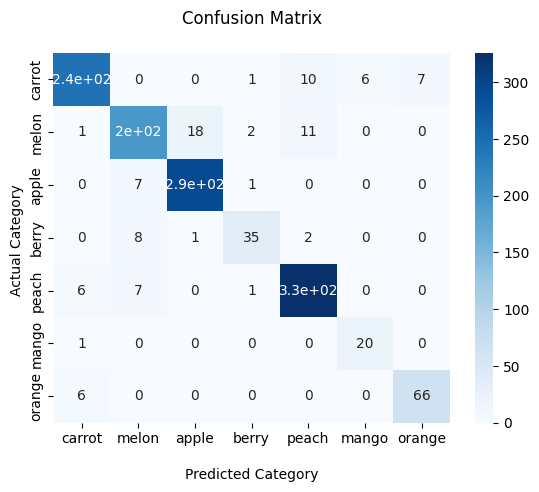

In [373]:

cf_matrix = confusion_matrix(y_test, s_ab_best_predictions)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

ax.xaxis.set_ticklabels(['carrot','melon', 'apple', 'berry', 'peach', 'mango', 'orange'])
ax.yaxis.set_ticklabels(['carrot','melon', 'apple', 'berry', 'peach', 'mango', 'orange'])

plt.show()

In [374]:
# now calculate the evaluation measures discussed in 1.ix
f1_score_macro = f1_score(y_test, s_ab_best_predictions, average='macro')
f1_score_weighted = f1_score(y_test, s_ab_best_predictions, average='weighted')
mcc = matthews_corrcoef(y_test, s_ab_best_predictions)
gmean = geometric_mean_score(y_test, s_ab_best_predictions)

print("Final measures on the best model (Ada boost) are:")
print(f"F1-score (macro average) = {f1_score_macro}")
print(f"F1-score (weighted  average) = {f1_score_weighted}")
print(f"Matthews Correlation Coefficient (MCC) = {mcc}")
print(f"Geometric Mean (Gmean) = {gmean}")

Final measures on the best model (Ada boost) are:
F1-score (macro average) = 0.8976786407361103
F1-score (weighted  average) = 0.9242145956345437
Matthews Correlation Coefficient (MCC) = 0.905059504739872
Geometric Mean (Gmean) = 0.901759755972669


# References

- [The Mystery of Feature Scaling is Finally Solved](https://towardsdatascience.com/the-mystery-of-feature-scaling-is-finally-solved-29a7bb58efc2)
- [10 Techniques to deal with Imbalanced Classes in Machine Learning](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)
- [How to Choose a Feature Selection Method For Machine Learning](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)
- [Scale, Standardize, or Normalize with Scikit-Learn](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)
- []()